# Tensors

Pour ce tp, veuillez installer ces packages : `pip install git+https://gitlab.in2p3.fr/jbarnier/ateliers_deep_learning.git`

Les tensors sont l'une des structure de données en pytorch. Ce sont des tableaux numérique qui peuvent être utilisé par CPU ou GPU.

In [2]:
import torch

In [3]:
list_a = [1.0, -4.0,9.0,16.0]
tensor_a = torch.tensor(list_a)
print(tensor_a)

tensor([ 1., -4.,  9., 16.])


Les calculs sur les tensors sont vectorisés. Les opérations sont donc effectué sur tout le tensor en une fois. Par exemple, ajouter une valeur à un tensors l'ajoute à chacun des éléments du tensors.

In [4]:
print(tensor_a + 2)

tensor([ 3., -2., 11., 18.])


Pytorch fournit plusieurs fonctions de calcul. Elles peuvent être appelé sous forme de fonction ou de méthode.

In [5]:
print(tensor_a.mean())
print(torch.mean(tensor_a))

tensor(5.5000)
tensor(5.5000)


**Exercice 1**

Soit la température en Fahrenheit pouvent être convertit en Celsius avec la formule suivant : 

$$T_{\textrm{Celsius}} = (T_{\textrm{Fahrenheit}} - 32) \times \frac{5}{9}$$

Crée une fonction `fahrenheit_to_celsius` qui convertit un tensor de température en Fahrenheit en Celsius. 

In [6]:
def fahrenheit_to_celsius(tensor):
    return (tensor - 32.0) * 5.0 / 9.0

temp_fahrenheit = torch.tensor([0,32,50,100])
print(fahrenheit_to_celsius(temp_fahrenheit))

tensor([-17.7778,   0.0000,  10.0000,  37.7778])


# Tensors gradients

Quand on crée un tensor, si on spécifie l'arguement `requires_grad =True` alors chaque objet créé en appliquant une opération de torch sur le tensors devriendra également un tensor qui gardera en mémoire les fonctions appliqué. 

In [7]:
w1 = torch.tensor(1.0 , requires_grad=True)
w2 = w1 + 2.0
w3 = torch.square(w2)
print(w3)
w3.backward()  # calcule la dérivée de w3 par rapport à w1
print(w1.grad)  # montre que w1 a une fonction de gradient associée

tensor(9., grad_fn=<PowBackward0>)
tensor(6.)


Un gradient sert à mesurer comment une quantité (souvent la perte) change quand on modifie les paramètres. Le gradient déterminé par la méthode `.backward()` utilise la règle de la chaîne pour calculer la dérivé. 

Principe : si y = f(g(x)), alors la dérivée dy/dx se calcule en multipliant la dérivée de f par rapport à g par la dérivée de g par rapport à x : dy/dx = f'(g(x)) * g'(x).


Ici on a : 
    $$w1 = 1$$
    $$w2 = w1 + 2 = 3$$
    $$w3 = w2**2 = 9$$

On a alors:
    $$dw3/dw1 = f'(g(w1)) * g'(w1)$$
            $$= f'(w2**2) * g'(w1)$$
            $$= 2 * w2 * 1$$
            $$= 2 * 3$$
            $$= 6$$

On obtient ici la pente instantannée en w1 = 1 de la dérivé. Cependant la dérivé donne une approximation linéaire locale.
Pour un petit pas Δw1, la variation de w3 est approximée par Δw3 ≈ (∂w3/∂w1) · Δw1. Cette approximation est bonne si Δw1 est petit.

Ce gradient va nous servir pour la descente de gradient appliqué à la fonction de perte (erreur du modèle) ce qui nous permettra de rendre les prédiction plus proches des vraies valeurs. (Attention on parle ici de la pente local et non global de la fonction donc pour des fonctions convexes  c'est l'idéal mais pour les fonctions non convexes on peut converger vers un minimum local qui n'est pas forcément le meilleur global).

**Exercice 2**

En utilisant les tensors :

-   calculer le gradient de la fonction $1 /\log{x}$ quand $x$ = 10. (Sauriez-vous déterminer la tendance de la fonction pour x =10 ? )
-   calculer le gradient de la fonction `farhenheit _to_celsius` quand $t$ = 0



In [8]:
# premier point d'exemple
a = torch.tensor(10.0, requires_grad=True)
a_1 = 1 / torch.log(a) 

a_1.backward()
print(a.grad)

# second point d'exemple
b = torch.tensor(0.0, requires_grad=True)
b_1 = fahrenheit_to_celsius(b)
b_1.backward()
print(b.grad)




tensor(-0.0189)
tensor(0.5556)


Quand le gradient est calculé sur une fonction avec un seul argument, la valeur correspond à la dérivé de la fonction pour un paramètre donnée.

Lorsque la fonction prend plusieurs argument en entrée, chaque valeur du gradient est la dérivée partiel de la fonction pour les paramètres données.

Pour illustrer cela, dans l’exemple suivant :

-   x1.grad est la dérivée partielle de x1/x2 par rapport à x1 lorsque x1 = 3 et x2 = 5.
-   x2.grad est la dérivée partielle de x1/x2 par rapport à x2 lorsque x1 = 3 et x2 = 5.
-   (x1.grad, x2.grad) est le gradient de x1/x2 au point (x1=3, x2=5).


In [9]:
x1 = torch.tensor(3.0, requires_grad=True)
x2 = torch.tensor(5.0, requires_grad=True)
res = x1 / x2
res.backward()
print(x1.grad, x2.grad)

tensor(0.2000) tensor(-0.1200)


**Exercise 3**

-   Créer une fonction `test_fn` qui prend deux argument `x1` et `x2` et calcul $\sqrt{x_1} / e^{x_2}$.
-   Calculer le gradient de `test_fn` quand $x_1 = 1$ et $x_2 = 2$

In [10]:
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(2.0, requires_grad=True)

def test_fn(a,b):
    return torch.sqrt(a) / torch.exp(b)

res = test_fn(a,b)
print(res)

res.backward()

print(a.grad,b.grad)



tensor(0.1353, grad_fn=<DivBackward0>)
tensor(0.0677) tensor(-0.1353)


# Descente de gradient

Pour la suite, imaginons que nous avons un tensor `x` avec 6 valeurs numérique.

In [11]:
x = torch.tensor([1.0,2.0,3.0,20.0,-15.0,-5.0])


Nous allons utiliser une fonction prédéfinit pour afficher les valeurs sur un axe.

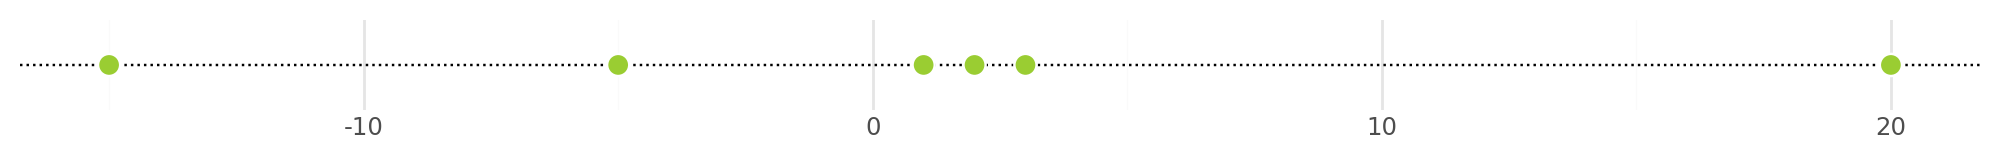

In [12]:
from adl.tensors import plot_points1d

plot_points1d(x)

Supposons que nous voulons trouver la valeur du paramètre `w` pour que la somme des distances au carré entre les valeurs de 
`x` et `w` soit minimal. 

Par exemple, on peut commencer par une valeur `w` de 0.

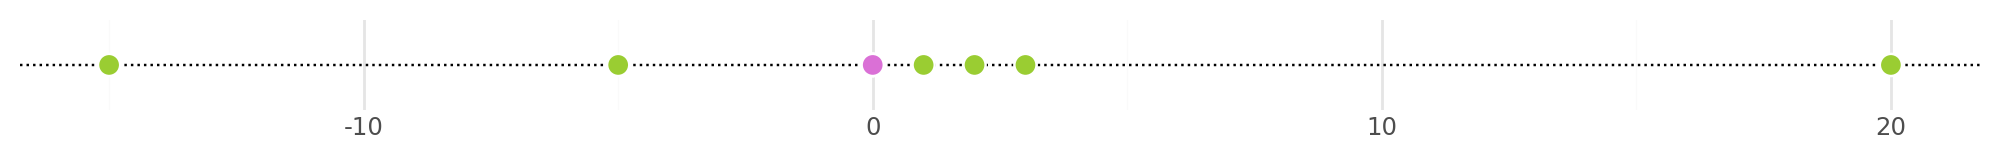

In [13]:
plot_points1d(x,0)

Pour évaluer si la distance pour `w` = 0 est minimal, on peut calculer le gradient de la fonction qui calcule la sommes des distances au carré entre les valeurs de `x` et `w` = 0.

In [14]:
w = torch.tensor(0.0, requires_grad=True)

y = (x-w).square().sum()

print(w)

y.backward()

print(w.grad)

tensor(0., requires_grad=True)
tensor(-12.)


**Point math**


On calcule la dérivée partielle en appliquant les règles de dérivation (règle de la somme, règle de la chaîne) en prenant la variable d'intérêt comme variable et en traitant les autres comme constantes. Ici nous avons 2 fonctions (le carré et la différence)

Pour bien comprendre, on va tout d'abors calculer la dérivé d'un terme i ( en suivant la règle de la chaîne et de la somme): 
- Poser u(w) = x_i − w (fonction interne).
- f_i(u) = u^2 (fonction externe).
- Appliquer la règle de la chaîne : df_i/dw = (df_i/du) · (du/dw).
- df_i/du = 2u = 2(x_i − w)
- du/dw = d(x_i − w)/dw = −1
- → df_i/dw = 2(x_i − w)·(−1) = 2(w − x_i).

Pour la somme y(w) = Σ_i f_i(w) on somme les dérivées :
- dy/dw = Σ_i 2(w − x_i) = 2·Σ_i(w) − 2·Σ_i(x_i) = 2·n·w − 2·Σ_i x_i,
- avec n = nombre d'éléments (Σ_i 1 = n).

On a alors : Σ_i x_i = 6 → dy/dw = 2·n·0 − 2·6 = −12 , avec x = [1,2,3,20,−15,−5] et w=0

(Attention ici on a bien un la même valeur pour n et Σ_i x_i, n représente le nombre de valeur dans le tensor X qui est de 6 et Σ_i x_i représente la somme des valeurs du tensor X.)

Etant donné que nous allons utiliser cette méthode plusieurs fois, nous allons créer une nouvelle fonction `eval_w_squared`

In [17]:
def eval_w_squared(w_value):
    x = torch.tensor([1.0,2.0,3.0,20.0,-15.0,-5.0])
    w = torch.tensor(w_value, requires_grad=True)
    y = (x-w).square().sum()
    y.backward()
    print(f"Sum of squares :{y}")
    print(f"Gradient : {w.grad}")

eval_w_squared(0.0)

Sum of squares :664.0
Gradient : -12.0


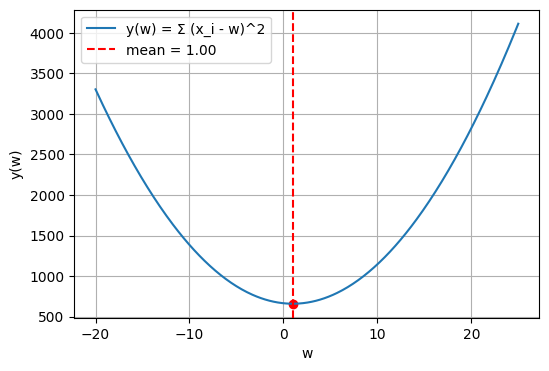

In [60]:
# python
import torch
import numpy as np
import matplotlib.pyplot as plt

x = torch.tensor([1.0,2.0,3.0,20.0,-15.0,-5.0])
xs = x.numpy()
n = x.numel()
s = xs.sum()
s2 = (xs**2).sum()

ws = np.linspace(xs.min()-5, xs.max()+5, 400)
# utilisation de la forme développée (plus stable et rapide)
ys = n * ws**2 - 2 * s * ws + s2

w_star = xs.mean()
y_star = n * w_star**2 - 2 * s * w_star + s2

plt.figure(figsize=(6,4))
plt.plot(ws, ys, label='y(w) = Σ (x_i - w)^2')
plt.axvline(w_star, color='r', linestyle='--', label=f'mean = {w_star:.2f}')
plt.scatter([w_star], [y_star], color='r')
plt.xlabel('w'); plt.ylabel('y(w)')
plt.legend(); plt.grid(True)
plt.show()

Donc la sommes des distances au carré est de 664 et son gradient de -12 quand `w` = 0.

Avec ces informations, on peut dire que `w` = 0 n'est pas la valeur optimal car le gradient n'est pas égale à zéro. ( Il faut avoir en tête le fait que nous voulons que notre fonction perte (erreur) donne le résultat le plus petit possible, ici en regardant la courbe on voit bien que zéro n'est pas la valeur optimal.)

Et que le gradient nous donne la "direction" que nous devons prendre pour ajuster la valeur de notre paramètre.

Quand `w` = 0, le gradient est négatif, ce qui signifie que si l'on prend un valeur plus petite de `w` la somme de la distance au carré augmentera et inversement.

On veut ici somme de la distance au carré minimale.


In [25]:
eval_w_squared(0.5)
eval_w_squared(1.0)
x.mean()

Sum of squares :659.5
Gradient : -6.0
Sum of squares :658.0
Gradient : 0.0


tensor(1.)

Maintenant notre gradient est égale à zéro, ce qui signifie que nous sommes à l'optimum local.
En faite, 1 est la moyenne de `x` qui est par définition la valeur qui minimise la somme de la distance au carré. 

**Exercice 4**

Créez une fonction `eval_w_abs` qui va calculer les sommes des valeurs absolues da la différence entre `x` et `w`.

Utilisez cette pour faire une descente de gradient et trouver la valeur de `w` qui minimise cette somme.

Quelle est la fonction statistique qu'on aurait pu utiliser pour trouver cette valeur directement ? 

In [32]:
def eval_w_abs(w_value):
    x = torch.tensor([1.0,2.0,3.0,20.0,-15.0,-5.0])
    w = torch.tensor(w_value, requires_grad=True)
    y = (x-w).abs().sum()
    y.backward()
    print(f"Sum of absolute differences :{y}")
    print(f"Gradient : {w.grad}")

eval_w_abs(1.5)

Sum of absolute differences :44.0
Gradient : 0.0


# Minimiser la fonction de perte

En depp learning, une des tâches principales est de minimiser une fonction de perte (loss function) afin d'améliorer les performances d'un modèle en ajutant les paramètre du modèle.

Par exemple, les deux listes suivant donne la température moyenne par mois à Lyon-Bron en 1924 et 2024 (source
[infoclimat](https://www.infoclimat.fr/stations-meteo/analyses-mensuelles.php?mois=12&annee=2024)).


In [34]:
lyon1924 = [3.1, 1.3, 7.7, 11.0, 15.7, 18.0, 20.6, 16.7, 16.2, 11.9, 7.3, 3.4]
lyon2024 = [5.3, 8.9, 10.9, 12.5, 15.9, 20.5, 23.3, 24.3, 17.4, 15.8, 8.7, 3.8]

Notre objectif ici est de prédire les températures de 2024 à partir des températures de 1924. Pour cette prédiction nous allons utiliser un modèle simple, on va ajouter une valeur fixe à toutes les températures de 1924 pour être le plus proche possible de celles de 2024.

Pour une notation plus formel, 

-   `x` est note variable d'entrée (les températures de 1924)
-   `y` est la valeur réel ou la valeur cible que nous voulons prédire (les températures de 2024)
-   Notre modèle est `y = x + w` , ou `w` est notre seul paramètre du modèle.
-   On veut `w` tel que sa valeur minimise la distance entre les prédictions et les vraies valeurs.

On comme par `w = 0`

In [35]:
x = torch.tensor(lyon1924)
y = torch.tensor(lyon2024)  
w = torch.tensor(0.0, requires_grad=True)

On peut maintenant calculer notre prédiction en appliquant notre modèle.

In [55]:
y_pred = x + w
print(y_pred)

tensor([ 3.1000,  1.3000,  7.7000, 11.0000, 15.7000, 18.0000, 20.6000, 16.7000,
        16.2000, 11.9000,  7.3000,  3.4000], grad_fn=<AddBackward0>)


On aimerait que ces prédictions soit aussi proche possible que les valeurs cible (température de 2024), donc on va calculer la distance entre `y_pred` et `y` en prenant la moyenne de la distance au carré entre les éléments.

On va appeler cette distance, la fonction de perte, celle que l'on veut minimiser.

On va calculer la fonction de perte (loss) pour `w = 0`

In [38]:
loss = torch.mean(torch.square(y_pred - y))
print(f"loss: {loss}")

loss: 13.766663551330566


On va appliquer la méthode `backward` comme précédemment pour déterminer le gradient pour `w = 0`. Pour rappel, on aimerait trouver le minimum local de notre fonction perte donc on cherche la valeur de `w` pour laquel on a un gradient de 0. 

In [39]:
loss.backward()
print(f"gradient for w at w=0: {w.grad}")

gradient for w at w=0: -5.733332633972168


Comme nous allons répéter ces actions, on va faire une fonction qui regroupe les étapes (calculer les prédiction, calculer la fonction de perte et calculer le gradient).

In [52]:
def eval_weight(x,y,w_value):
    w = torch.tensor(w_value, requires_grad=True)
    y_pred = x + w
    loss = torch.mean(torch.square(y_pred - y))
    loss.backward()
    print(f"w: {w_value}, loss: {loss.item()}, gradient: {w.grad.item()}")

eval_weight(x,y,0.0)

w: 0.0, loss: 13.766663551330566, gradient: -5.733332633972168


Comme nous l'avons vu précédemment, le gradient nous donne la direction dans laquelle cherche pour que la fonction de perte soit à son minimum local. Dans ce cas le gradient est négatif donc cela signifie qu'il faut augmenter la valeur de `w` pour avoir un gradient de 0 et donc être au minimum local de la fonction de perte.

In [41]:
eval_weight(x,y,5.0)

w: 5.0, loss: 10.100001335144043, gradient: 4.26666784286499


Ici nous somme au-dessus de 0 pour la gradient donc `w = 5` est trop grand.

In [50]:
eval_weight(x,y,2.86666666667)
torch.mean(y - x)

w: 2.86666666667, loss: 5.548887252807617, gradient: 5.960464477539062e-07


tensor(2.8667)

# Processus de descente de gradient automatique

Jusqu'à maintenant on faisait la descente de gradient à la main, en sélectionnant la valeur de `w` à la main en fonction du signe du gradient.
On va maintenant voir comment automatiser le processus.

Par convention, la phase de prédiction est définit dans une fonction appelé `forward` qui prend nos données d'entrée ( le tensor `x`) et applique les différentes opérations (notre modèle) pour déterminer les prédictions.

Nous allons reprendre notre exemple sur les températures. On definit nos données d'entrée `x`, nos vrais valeurs `y`, et le paramètre de notre modèle `w` et une méthode forward qui va calculer les prédictions en appliquant notre modèle, ici `x+w`.

In [75]:
lyon1924 = [3.1, 1.3, 7.7, 11.0, 15.7, 18.0, 20.6, 16.7, 16.2, 11.9, 7.3, 3.4]
lyon2024 = [5.3, 8.9, 10.9, 12.5, 15.9, 20.5, 23.3, 24.3, 17.4, 15.8, 8.7, 3.8]

x = torch.tensor(lyon1924)
y = torch.tensor(lyon2024)

w = torch.tensor(0.0, requires_grad=True)


def forward(x):
    return x + w

Maintenant nous allons définir notre fonction de perte (mesure de la distance) entre nos valeur prédite et les vraies valeurs. Cette fonction de perte peut être définit manuellement mais on peut également utiliser des fonction de perte prédifini dans Pytorch. Par exemple, notre fonction de perte peut utiliser `torch.nn.MSELoss` qui calcul la moyenne de l'erreur au carré.

In [76]:
loss_fn = torch.nn.MSELoss()

Comme précédemment, les bases de l'entraînement est d'appliquer la fonction `forward à x` pour calculer les prédictions avec le paramètre de notre modèle `w`. Ensuite on calcul la fonction de perte `loss` (distance entre les valeurs prédite et les vraies valeurs) et enfin d'appeler `backward` pour calculer le gradient de la fonction de perte en `w`.

In [74]:
y_pred = forward(x)

loss = loss_fn(y_pred, y)

loss.backward()

print(f"loss: {loss.item()}, gradient: {w.grad.item()}")

loss: 13.766663551330566, gradient: -5.733332633972168


Pour compléter cette étape et avoir un vrai entraînement du modèle, on doit ajuster `w` (jusqu'ici nous le faisions manuellement), on doit ajuster `w` dans la direction opposé de son gradient (imaginons un repère sur lequelle nous avons une courbe comme ci-dessous, imaginons un gradient de -12, cela signifie qu'il faut tracer une droite avec une pente de -12, cela signifie que l'on se trouve a gauche de la ligne rouge on doit alors augmenter `w` pour atteindre le minimum de notre fonction de perte (bleu), on trouve le raisonnement inverse dans le cas ou notre gradient est positif). 

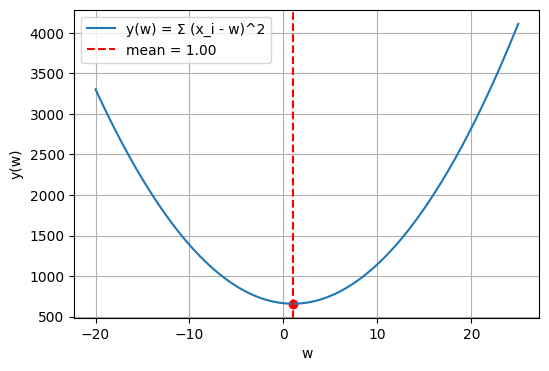

La méthode la plus simple est de soustraire à `w` la valeur du gradient multiplié par un facteur que l'on appelle, le `taux d'apprentissage`. En effet, si le gradient `w.grad` est négatif on va ajouter la nouvelle valeur et donc se déplacer dans le sens opposé au gradient et inversement.

In [66]:
print(w)
learning_rate = 0.1
w.data = w.data - learning_rate * w.grad
print(f"Updated w: {w.item()}")

tensor(0., requires_grad=True)
Updated w: 0.5733332633972168


Pour lancer l'entraînement il faut donc répéter cette étape, c'est pourquoi nous allons faire une boucle avec un certains nombre d'itérations `epochs`.

Il faut également prendre en compte que à la fin de chaque étape d'entraînement nous devons ré-initialiser le gradient `w` en appellant `w.grad.zero_`

In [77]:
epochs = 20

for epoch in range(epochs):
    y_pred = forward(x)
    loss = loss_fn(y_pred,y)
    loss.backward()
    w.data = w.data - learning_rate * w.grad
    print(f"Epoch {epoch+1}: loss={loss.item()}, gradient: {w.grad}, w={w.item()}")

    w.grad.zero_()

Epoch 1: loss=13.766663551330566, gradient: -5.733332633972168, w=0.5733332633972168
Epoch 2: loss=10.808262825012207, gradient: -4.586666107177734, w=1.0319998264312744
Epoch 3: loss=8.91489028930664, gradient: -3.6693332195281982, w=1.3989331722259521
Epoch 4: loss=7.703128337860107, gradient: -2.9354662895202637, w=1.6924798488616943
Epoch 5: loss=6.927601337432861, gradient: -2.3483729362487793, w=1.9273171424865723
Epoch 6: loss=6.431265354156494, gradient: -1.8786985874176025, w=2.115186929702759
Epoch 7: loss=6.113610744476318, gradient: -1.5029590129852295, w=2.2654829025268555
Epoch 8: loss=5.910308837890625, gradient: -1.2023664712905884, w=2.3857195377349854
Epoch 9: loss=5.780198574066162, gradient: -0.9618936777114868, w=2.4819087982177734
Epoch 10: loss=5.696925640106201, gradient: -0.7695151567459106, w=2.5588603019714355
Epoch 11: loss=5.643632411956787, gradient: -0.6156118512153625, w=2.6204214096069336
Epoch 12: loss=5.609523773193359, gradient: -0.49248945713043213,

**Exercice 5**

Nous avons deux listes Python qui donnent les diamètres mesurés et les périmètres d’un certain nombre de cercles.

Utilisez PyTorch pour lancer un processus d’entraînement afin de trouver la meilleure valeur du paramètre w qui permet de prédire les périmètres à partir des diamètres. Le modèle pour calculer les valeurs prédites est y = x × w.

Indice : vous pouvez utiliser un pas (taux d’apprentissage) de 0,01.

In [85]:
diameters = [1.4, 2.5, 2.0, 4.8, 4.7, 5.2, 1.3, 2.1, 8.3, 7.4]
perimeters = [4.4, 7.9, 6.3, 15.1, 14.8, 16.3, 4.1, 6.6, 26.1, 23.2]

In [ ]:
def training_model(diameters,perimeters,param,epochs,learning_rate):
    x = torch.tensor(diameters)
    y = torch.tensor(perimeters)

    w = torch.tensor(param, requires_grad=True)

    def forward(x):
        return x * w

    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        y_pred = forward(x)
        loss = loss_fn(y_pred,y)
        loss.backward()
        w.data = w.data - learning_rate * w.grad
        print(f"Epoch {epoch+1}: loss={loss.item()}, gradient: {w.grad}, w={w.item()}")
        w.grad.zero_()
    
        

training_model(diameters,perimeters,0.0,100,0.01)

Epoch 1: loss=211.4020233154297, gradient: -134.56199645996094, w=1.3456199169158936
Epoch 2: loss=69.10506439208984, gradient: -76.93448638916016, w=2.114964723587036
Epoch 3: loss=22.590091705322266, gradient: -43.98652267456055, w=2.5548300743103027
Epoch 4: loss=7.384963035583496, gradient: -25.14885139465332, w=2.806318521499634
Epoch 5: loss=2.414613962173462, gradient: -14.3786039352417, w=2.9501044750213623
Epoch 6: loss=0.789872944355011, gradient: -8.220823287963867, w=3.0323126316070557
Epoch 7: loss=0.25876736640930176, gradient: -4.700179100036621, w=3.0793144702911377
Epoch 8: loss=0.08515530079603195, gradient: -2.6872775554656982, w=3.106187343597412
Epoch 9: loss=0.028403952717781067, gradient: -1.536422848701477, w=3.121551513671875
Epoch 10: loss=0.00985276885330677, gradient: -0.8784356117248535, w=3.130335807800293
Epoch 11: loss=0.003788607893511653, gradient: -0.5022363066673279, w=3.1353580951690674
Epoch 12: loss=0.0018063448369503021, gradient: -0.287152767181